# **Data Science Practicum: Weather and Air Quality Analysis**

### Project Overview:

This project analyzes the relationship between meteorological conditions and air quality in major U.S. cities. The analysis begins with a classification model to determine if current weather can predict the current air quality category. After discovering key data challenges, the project pivots to a more advanced time series forecasting model to predict the next day's PM2.5 levels.

## Importing Libraries

In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

## **Data Collection**

### Data Collection: Weather Data

In [2]:
# Weather Data
weather_url = "https://archive-api.open-meteo.com/v1/archive"

cities = {
    "New York": (40.7128, -74.0060, "36"),   # New York
    "Los Angeles": (34.0522, -118.2437, "06"), # California
    "Houston": (29.7604, -95.3698, "48"),    # Texas
    "Phoenix": (33.4484, -112.0740, "04"),   # Arizona
    "Denver": (39.7392, -104.9903, "08")     # Colorado
}

base_params = {
    'start_date': '2023-01-01',
    'end_date': '2025-10-05',   # Match AQI year
    'daily': 'temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,relative_humidity_2m_mean,surface_pressure_mean', # Added humidity and pressure
    'timezone': 'America/New_York'
}

weather_data = []

for city, (lat, lon, state_code) in cities.items():
    params = base_params.copy()
    params.update({'latitude': lat, 'longitude': lon})
    response = requests.get(weather_url, params=params).json()

    if "daily" in response:
        df = pd.DataFrame(response["daily"])
        df["date"] = pd.to_datetime(df["time"])
        df["city"] = city
        df["state"] = state_code
        weather_data.append(df)
    else:
        print(f"No weather data for {city}")

weather_df = pd.concat(weather_data, ignore_index=True)

# Update the selection to include the new columns
weather_df = weather_df[[
    "date", "city", "state", "temperature_2m_max", "temperature_2m_min",
    "precipitation_sum", "wind_speed_10m_max", "relative_humidity_2m_mean", "surface_pressure_mean"
]]

print("Weather DataFrame with all features:")
print(weather_df.head())

Weather DataFrame with all features:
        date      city state  temperature_2m_max  temperature_2m_min  \
0 2023-01-01  New York    36                11.8                 4.8   
1 2023-01-02  New York    36                12.7                 4.4   
2 2023-01-03  New York    36                12.7                 6.2   
3 2023-01-04  New York    36                17.9                 9.4   
4 2023-01-05  New York    36                13.0                 7.3   

   precipitation_sum  wind_speed_10m_max  relative_humidity_2m_mean  \
0                2.1                17.4                         84   
1                0.5                 9.0                         83   
2                9.5                19.4                         97   
3                2.3                18.2                         94   
4                0.0                12.1                         93   

   surface_pressure_mean  
0                 1008.4  
1                 1015.6  
2                 1011

### Data Collection: Air Quality Data (PM2.5)

In [3]:
# Air Quality Data by County
aqs_url = "https://aqs.epa.gov/data/api/dailyData/byCounty"
email = "rameswaramkumarviswanath@gmail.com"
key = "amberkit41"

cities = {
    "New York": ("36", "061"),
    "Los Angeles": ("06", "037"),
    "Houston": ("48", "201"),
    "Phoenix": ("04", "013"),
    "Denver": ("08", "031")
}

aqs_data = []
years = ["2023", "2024", "2025"] # List of years to fetch

for city, (state, county) in cities.items():
    for year in years:
        params = {
            "email": email,
            "key": key,
            "param": "88101",  # PM2.5
            "bdate": f"{year}0101",
            "edate": f"{year}1231",
            "state": state,
            "county": county
        }
        r = requests.get(aqs_url, params=params).json()
        if "Data" in r and len(r["Data"]) > 0:
            df = pd.DataFrame(r["Data"])
            df["date"] = pd.to_datetime(df["date_local"])
            df["city"] = city
            df = df[["date", "city", "arithmetic_mean"]]
            aqs_data.append(df)
        else:
            print(f"No AQI data for {city} in {year}")

all_aqs_df = pd.concat(aqs_data, ignore_index=True)

# Aggregate AQI data by date and city
aggregated_aqs_df = all_aqs_df.groupby(['date', 'city'])['arithmetic_mean'].mean().reset_index()
print("\nAggregated AQI DataFrame:")
print(aggregated_aqs_df)


Aggregated AQI DataFrame:
           date         city  arithmetic_mean
0    2023-01-01       Denver        11.834874
1    2023-01-01      Houston        23.200702
2    2023-01-01  Los Angeles         5.176806
3    2023-01-01      Phoenix        46.158974
4    2023-01-02       Denver         8.302911
...         ...          ...              ...
4041 2025-08-29  Los Angeles         8.502778
4042 2025-08-30       Denver         8.645604
4043 2025-08-30  Los Angeles         8.310185
4044 2025-08-31       Denver         6.907037
4045 2025-08-31  Los Angeles         8.508796

[4046 rows x 3 columns]


## **Data Preparation**

### Merging Datasets

In [4]:
# Merging datasets
final_df = pd.merge(
    weather_df,
    aggregated_aqs_df,
    on=["date","city"],
    how="inner"
)

final_df.rename(columns={"arithmetic_mean":"pm25"}, inplace=True)
print(final_df)

           date      city state  temperature_2m_max  temperature_2m_min  \
0    2023-01-03  New York    36                12.7                 6.2   
1    2023-01-06  New York    36                 8.6                 3.2   
2    2023-01-09  New York    36                 7.1                 0.6   
3    2023-01-12  New York    36                 9.6                -0.7   
4    2023-01-15  New York    36                 5.0                -1.8   
...         ...       ...   ...                 ...                 ...   
4041 2025-08-27    Denver    08                24.3                15.8   
4042 2025-08-28    Denver    08                24.4                12.8   
4043 2025-08-29    Denver    08                24.8                12.9   
4044 2025-08-30    Denver    08                21.9                13.6   
4045 2025-08-31    Denver    08                24.9                10.6   

      precipitation_sum  wind_speed_10m_max  relative_humidity_2m_mean  \
0                   9.5  

## **Exploratory Data Analysis (EDA)**

In [5]:
print("\nMissing values in each column:")
print(final_df.isnull().sum())


Missing values in each column:
date                         0
city                         0
state                        0
temperature_2m_max           0
temperature_2m_min           0
precipitation_sum            0
wind_speed_10m_max           0
relative_humidity_2m_mean    0
surface_pressure_mean        0
pm25                         0
dtype: int64


## **Correlation Analysis**

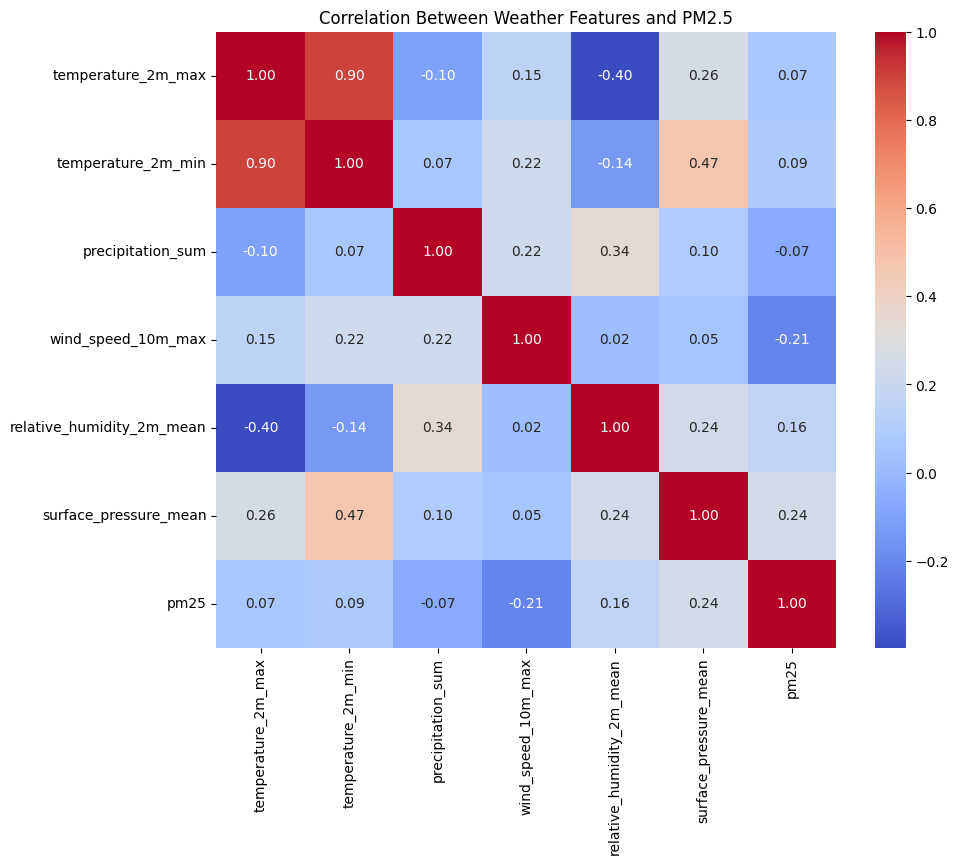

In [6]:
# Only numeric columns for correlation
numeric_df = final_df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Weather Features and PM2.5')
plt.show()

## **Classification Modeling**

### Feature Engineering

In [7]:
def get_aqi_category(pm25):
    if 0 <= pm25 <= 12.0:
        return 'Good'
    elif 12.1 <= pm25 <= 35.4:
        return 'Moderate'
    elif 35.5 <= pm25 <= 55.4:
        return 'Unhealthy for Sensitive Groups'
    elif 55.5 <= pm25 <= 150.4:
        return 'Unhealthy'
    else:
        return 'Very Unhealthy'

final_df['aqi_category'] = final_df['pm25'].apply(get_aqi_category)
print("\nDataFrame with AQI Category:")
print(final_df[['city', 'pm25', 'aqi_category']].head())


DataFrame with AQI Category:
       city       pm25 aqi_category
0  New York  20.200000     Moderate
1  New York   6.833333         Good
2  New York   9.350000         Good
3  New York   8.700000         Good
4  New York   4.400000         Good


### Addressing Imbalance: Re-framing as a Binary Problem

In [8]:
# Create a new binary target column
# We'll group 'Moderate' and worse into an 'Unacceptable' category
final_df['binary_aqi'] = final_df['aqi_category'].apply(lambda x: 'Good' if x == 'Good' else 'Not Good')

In [9]:
# Check the new distribution - it will be much more balanced!
print(final_df['binary_aqi'].value_counts())

binary_aqi
Good        3258
Not Good     788
Name: count, dtype: int64


In [10]:
# Display the distribution of AQI categories
print("Air Quality Category Distribution:")
print(final_df['aqi_category'].value_counts())

Air Quality Category Distribution:
aqi_category
Good                              3258
Moderate                           752
Very Unhealthy                      17
Unhealthy for Sensitive Groups      14
Unhealthy                            5
Name: count, dtype: int64


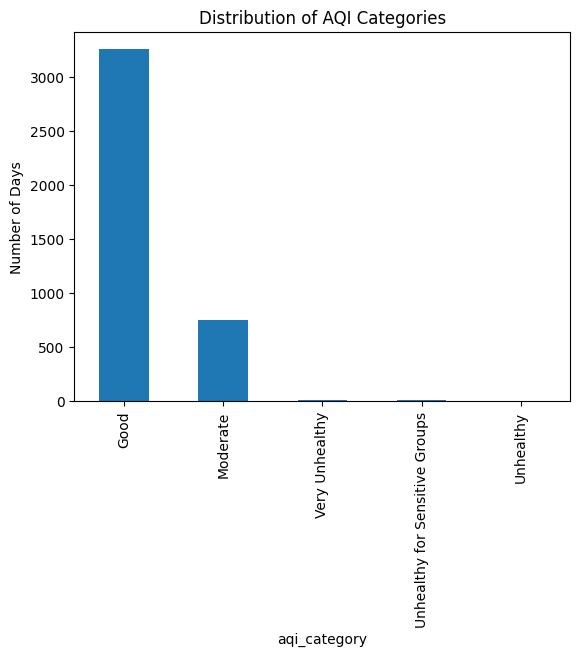

In [11]:
# Optional: You can also create a quick bar plot
final_df['aqi_category'].value_counts().plot(kind='bar')
plt.title('Distribution of AQI Categories')
plt.ylabel('Number of Days')
plt.show()

## **Model Training and Evaluation (Binary Classification)**

In [12]:
# Define features (X) and target (y)
features = ['temperature_2m_max', 'temperature_2m_min', 'precipitation_sum',
            'wind_speed_10m_max', 'relative_humidity_2m_mean', 'surface_pressure_mean']
target = 'binary_aqi'

In [13]:
# One-hot encode the 'city' column and add it to features
X = pd.get_dummies(final_df[['city'] + features], drop_first=True)
y = final_df[target]

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [15]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

print("\n--- Random Forest Classifier Results ---")
print(f"Accuracy: {accuracy_score(y_test, rf_predictions):.4f}")
print(classification_report(y_test, rf_predictions))


--- Random Forest Classifier Results ---
Accuracy: 0.8328
              precision    recall  f1-score   support

        Good       0.86      0.95      0.90       978
    Not Good       0.63      0.33      0.43       236

    accuracy                           0.83      1214
   macro avg       0.74      0.64      0.67      1214
weighted avg       0.81      0.83      0.81      1214



In [16]:
# Logistic Regression (Baseline)
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

print("\n--- Logistic Regression Results ---")
print(f"Accuracy: {accuracy_score(y_test, lr_predictions):.4f}")
print(classification_report(y_test, lr_predictions))


--- Logistic Regression Results ---
Accuracy: 0.6466
              precision    recall  f1-score   support

        Good       0.91      0.63      0.74       978
    Not Good       0.32      0.73      0.45       236

    accuracy                           0.65      1214
   macro avg       0.61      0.68      0.59      1214
weighted avg       0.79      0.65      0.68      1214



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
# Using the predictions from your Random Forest model
cm = confusion_matrix(y_test, rf_predictions, labels=rf_model.classes_)

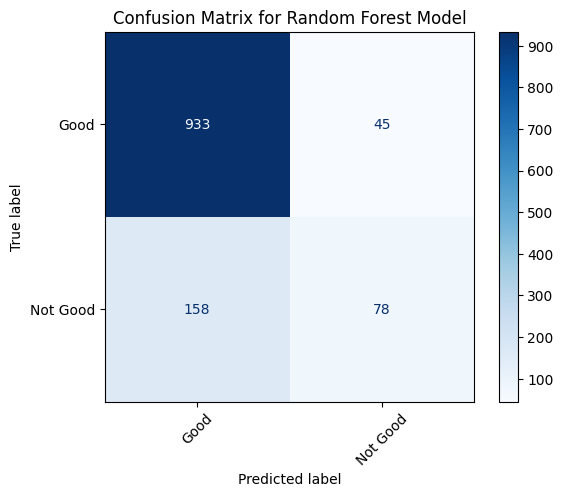

In [18]:
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Random Forest Model')
plt.xticks(rotation=45)
plt.show()

In [19]:
# Extract feature importances from the trained Random Forest model
importances = rf_model.feature_importances_
feature_names = X_train.columns

In [20]:
# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

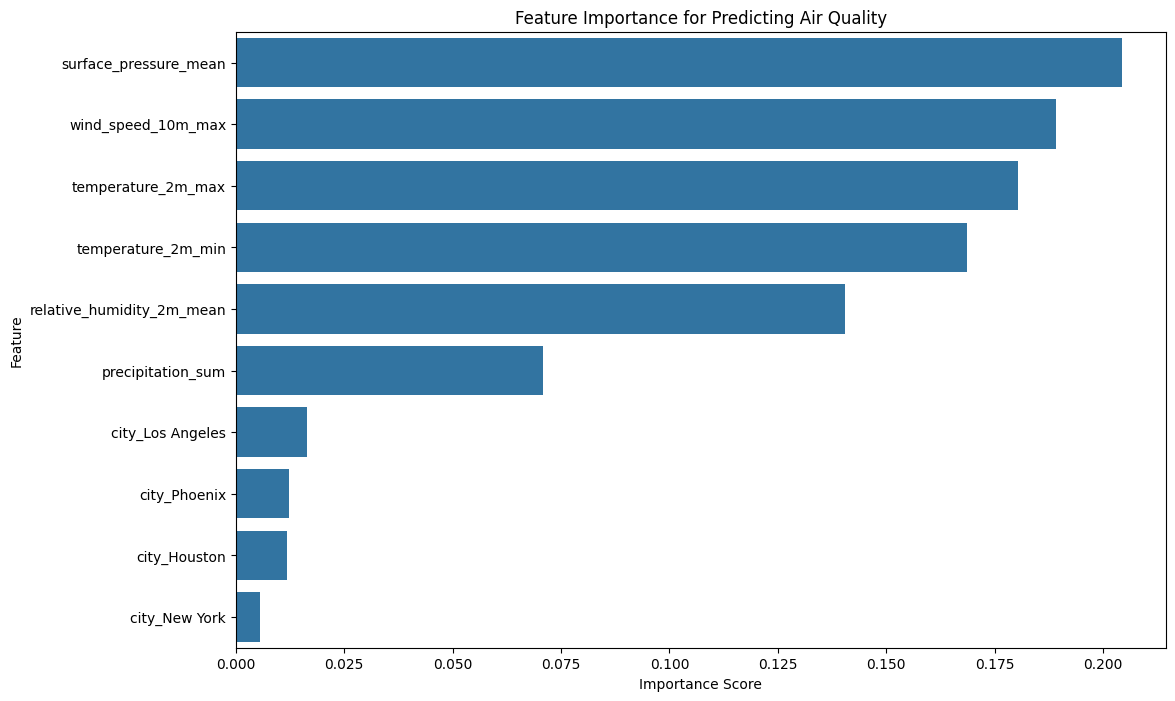

In [21]:
# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance for Predicting Air Quality')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [39]:
# City coordinates from your data collection script
city_coords = {
    "New York": (40.7128, -74.0060),
    "Los Angeles": (34.0522, -118.2437),
    "Houston": (29.7604, -95.3698),
    "Phoenix": (33.4484, -112.0740),
    "Denver": (39.7392, -104.9903)
}

# Calculate average pm25 per city
city_avg_pm25 = final_df.groupby('city')['pm25'].mean()

# Create a map centered on the US
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Add markers for each city
for city, avg_pm25 in city_avg_pm25.items():
    lat, lon = city_coords[city]
    folium.CircleMarker(
        location=[lat, lon],
        radius=avg_pm25 / 2, # Radius can be proportional to pollution
        popup=f'{city}<br>Avg PM2.5: {avg_pm25:.2f}',
        color='crimson',
        fill=True,
        fill_color='crimson'
    ).add_to(m)
# Display the map
m

## **Time Series Forecasting**

### Feature Engineering for Forecasting

In [23]:
# Selected data for one city and it's sorted by date
denver_df = final_df[final_df['city'] == 'Denver'].copy()
denver_df = denver_df.sort_values('date')
denver_df.set_index('date', inplace=True)

In [24]:
# Added Time-Based Features
denver_df['day_of_week'] = denver_df.index.dayofweek
denver_df['month'] = denver_df.index.month
denver_df['day_of_year'] = denver_df.index.dayofyear

In [25]:
# Create lag features
for i in range(1, 4):
    denver_df[f'pm25_lag_{i}'] = denver_df['pm25'].shift(i)
    denver_df[f'temp_max_lag_{i}'] = denver_df['temperature_2m_max'].shift(i)
    denver_df[f'humidity_lag_{i}'] = denver_df['relative_humidity_2m_mean'].shift(i)
    denver_df[f'wind_speed_lag_{i}'] = denver_df['wind_speed_10m_max'].shift(i)

In [26]:
# Added Rolling Window Features
denver_df['pm25_rolling_mean_7'] = denver_df['pm25'].shift(1).rolling(window=7).mean()

In [27]:
# Drop rows with NaN values created by shift() and rolling()
denver_df.dropna(inplace=True)
print("\nDataFrame head with all new features:")
print(denver_df.head())


DataFrame head with all new features:
              city state  temperature_2m_max  temperature_2m_min  \
date                                                               
2023-01-08  Denver    08                 6.1               -13.5   
2023-01-09  Denver    08                 6.7               -13.4   
2023-01-10  Denver    08                 9.4                -7.5   
2023-01-11  Denver    08                 1.6                -5.0   
2023-01-12  Denver    08                 3.6               -10.4   

            precipitation_sum  wind_speed_10m_max  relative_humidity_2m_mean  \
date                                                                           
2023-01-08                0.0                14.7                         68   
2023-01-09                0.0                20.1                         68   
2023-01-10                0.0                14.8                         69   
2023-01-11                1.4                15.5                         84   
2023

In [28]:
# The target is the current day's pm25 value
y = denver_df['pm25']

In [29]:
# The features are all the lag columns you created
X = denver_df.drop(columns=['pm25', 'city', 'state', 'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum', 'wind_speed_10m_max', 'relative_humidity_2m_mean', 'surface_pressure_mean', 'aqi_category', 'binary_aqi'])

## **Forecasting Model Training and Evaluation**

In [30]:
# Split the data into a training and testing set based on time
split_date = '2024-06-01'
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]

y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

In [31]:
# Initialize and train the model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [32]:
# Make predictions
predictions = rf_regressor.predict(X_test)

In [33]:
# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error on Test Set: {mae:.2f}')

Mean Absolute Error on Test Set: 2.30


### Visualizing Forecast Performance

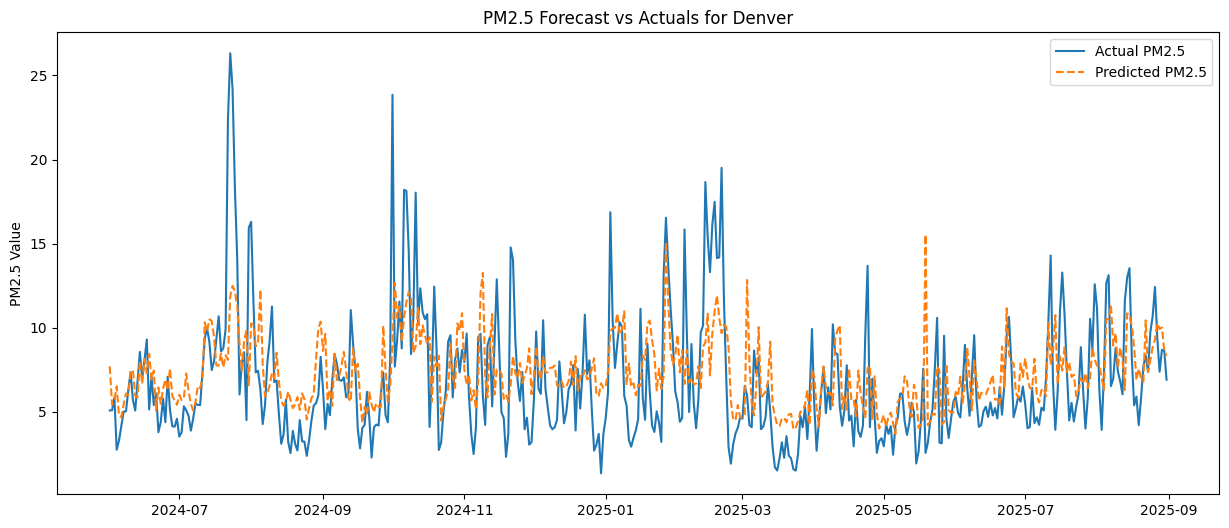

In [34]:
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Actual PM2.5')
plt.plot(y_test.index, predictions, label='Predicted PM2.5', linestyle='--')
plt.title('PM2.5 Forecast vs Actuals for Denver')
plt.ylabel('PM2.5 Value')
plt.legend()
plt.show()

### Forecasting Model Analysis: Feature Importance


In [35]:
# Add this in a new cell after your model is trained
importances = rf_regressor.feature_importances_
feature_names = X_train.columns

In [36]:
# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

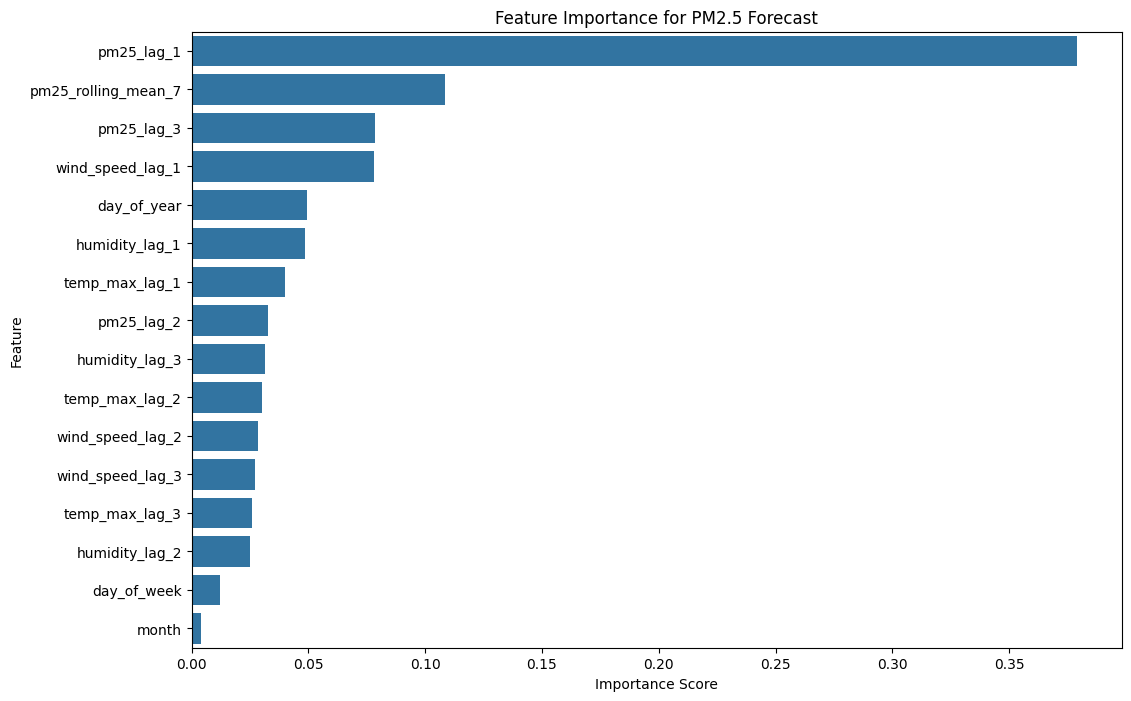

In [37]:
# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance for PM2.5 Forecast')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()